#  Creacion de modelos de machine learning para analisis y predicciones muertes prenatales en embarazos de medellin

In [ ]:
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importamos librerias 
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
#libreria para guardar y cargar modelos
import pickle


# Limpieza de datos

In [ ]:
#importamos los datos de csv en un dataframe de pandas
dataBruto = pd.read_csv("embarazos_medellin.csv", sep = ";")
dataBruto.drop('ID', axis=1, inplace=True) #eliminamos columna id

#columnas del dataframe
dataBruto.info()

#ejemplo de los datos
display(dataBruto.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277292 entries, 0 to 277291
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CODPTORE          277292 non-null  int64  
 1   CODMUNRE          277292 non-null  int64  
 2   fecha_nacimiento  277292 non-null  object 
 3   ANO               277292 non-null  int64  
 4   MES               277292 non-null  int64  
 5   TIPO_PRODUCTO     277292 non-null  object 
 6   SEXO              277292 non-null  int64  
 7   EDAD_MADRE        277292 non-null  int64  
 8   SEG_SOCIAL        277292 non-null  int64  
 9   IDCLASADMI        261656 non-null  object 
 10  COD_COMUNA_RES    277292 non-null  int64  
 11  BARRIO_RES        277292 non-null  object 
 12  APORTE_EMB        277292 non-null  float64
dtypes: float64(1), int64(8), object(4)
memory usage: 27.5+ MB


,CODPTORE,CODMUNRE,fecha_nacimiento,ANO,MES,TIPO_PRODUCTO,SEXO,EDAD_MADRE,SEG_SOCIAL,IDCLASADMI,COD_COMUNA_RES,BARRIO_RES,APORTE_EMB
0,5,1,2012-11-03T00:00:00.000-05:00,2012,11,Producto muerto,3,41,1,EPS SURA,15,Cristo Rey,1.0
1,5,1,2012-04-08T00:00:00.000-05:00,2012,4,Producto muerto,3,26,1,EPS SURA,3,Las Granjas,1.0
2,5,1,2012-03-31T00:00:00.000-05:00,2012,3,Producto muerto,3,36,1,EPS SURA,12,Calasanz Parte Alta,1.0
3,5,1,2012-04-25T00:00:00.000-05:00,2012,4,Producto muerto,3,28,1,E.P.S. SANITAS S.A.,16,Diego Echavarría,1.0
4,5,1,2012-06-15T00:00:00.000-05:00,2012,6,Producto muerto,3,36,1,EPS SURA,7,El Diamante,1.0


In [ ]:
#Eliminacion de datos duplicados
data = dataBruto.drop_duplicates()
#Eliminacion de registros faltantes
#data = dataBruto.dropna()
#cambiamos datos faltantes por su moda
imputer = SimpleImputer(strategy='most_frequent') 
columnas_faltantes = data.columns[data.isna().any()].tolist() # Selecciona las columnas con valores faltantes
data[columnas_faltantes] = imputer.fit_transform(data[columnas_faltantes])
#Calculamos porcentaje de datos eliminados
tamaño_original = dataBruto.shape[0]
tamaño_actual = data.shape[0]
print(f"Tamaño original = {tamaño_original} \n Tamaño actual {tamaño_actual} \n porcentaje de datos eliminados = {100-(tamaño_actual*100/tamaño_original)}% ")

Tamaño original = 277292 
 Tamaño actual 275126 
 porcentaje de datos eliminados = 0.7811260332068741% 


<ipython-input-73-7edcefe1aa84>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columnas_faltantes] = imputer.fit_transform(data[columnas_faltantes])


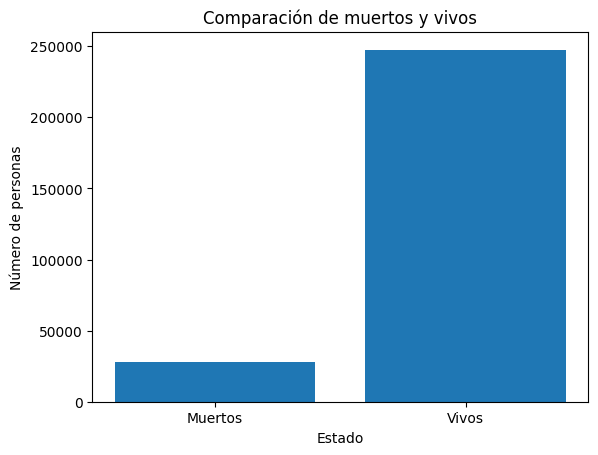

In [ ]:
#comparacion de categorias de la variable objetivo, tipo de producto
producto_column = data["TIPO_PRODUCTO"]
muertos = len([ p for p in producto_column if p == "Producto muerto"])
vivos = len([ p for p in producto_column if p == "Producto vivo"])
#grafico
nombres_barras = ['Muertos', 'Vivos']
datos_barras = [muertos, vivos]
plt.bar(nombres_barras, datos_barras)
plt.title('Comparación de muertos y vivos')
plt.xlabel('Estado')
plt.ylabel('Número de personas')
plt.show()

In [ ]:
#eliminamos columnas con datos no aportantes al ambito
data.drop(["CODPTORE", "CODMUNRE", "fecha_nacimiento"], axis=1, inplace=True) #eliminamos departamento y municipio pues todos los datos son en medellin, y la fecha ya es dada por otras columnas
#departamento y municipio son redundantes pues esta base de datos es en medellin , y fecha de nacimiento se encuentra en otras tablas
cols_cat = data.columns.tolist()
for col in cols_cat: #miramos el numero de niveles que tiene cada columna
  print(f'Columna {col}: {data[col].nunique()} subniveles')

Columna ANO: 9 subniveles
Columna MES: 12 subniveles
Columna TIPO_PRODUCTO: 2 subniveles
Columna SEXO: 3 subniveles
Columna EDAD_MADRE: 46 subniveles
Columna SEG_SOCIAL: 6 subniveles
Columna IDCLASADMI: 153 subniveles
Columna COD_COMUNA_RES: 22 subniveles
Columna BARRIO_RES: 317 subniveles
Columna APORTE_EMB: 4 subniveles


<ipython-input-75-4d6bb65a01e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["CODPTORE", "CODMUNRE", "fecha_nacimiento"], axis=1, inplace=True) #eliminamos departamento y municipio pues todos los datos son en medellin, y la fecha ya es dada por otras columnas


El numero de subniveles de las columnas  categoricas  año, mes, tipo producto, sexo, seguridad social, codigo de comuna, aporte embarazo se ajustan al numero dado por la base de datos.

Por la alta cantidad de categorias de BARRIO_RES y IDCLASAADMI que son barrio de residencia y el ombre de la entidad administradora en salud respectivamente, es inviable encontrar datos mal copiados.

In [ ]:
#transformar datos categoricos a numericos usando binary encoding
display(data["BARRIO_RES"])
col_categoricas = ["IDCLASADMI", "BARRIO_RES"] #variables categoricas que no han sido procesadas
encoders = []
for column_name in col_categoricas:
  column = data[column_name] #guardamos la columna 
  binary_encoder = BinaryEncoder(cols=[column_name]) #creamos el objetos 
  binary_encoder.fit(column) #entrenamos con la columna
  encoders.append(binary_encoder) #guardamos en la lista
  columna_encoder = binary_encoder.transform(column) #creamos las columnas codificadas 
  data = pd.concat([data, columna_encoder], axis=1) #guaradamos las columnas codificadas en el dataframe
  data.drop([column_name],axis=1, inplace=True )

#trandormar dato categorico de "tipo producto" a numerico
# Creamos un diccionario de reemplazo
reemplazo = {"Producto vivo": 0, "Producto muerto": 1}

# Usamos la función replace()
columna_tipo_producto = data["TIPO_PRODUCTO"]
data["TIPO_PRODUCTO"] = columna_tipo_producto.replace(reemplazo)


data.info()


0                   Cristo Rey
1                  Las Granjas
2          Calasanz Parte Alta
3             Diego Echavarría
4                  El Diamante
                  ...         
277287              El Triunfo
277288    Alejandro Echavarria
277289                 Robledo
277290             La Pilarica
277291                 La Mota
Name: BARRIO_RES, Length: 275126, dtype: object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275126 entries, 0 to 277291
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ANO             275126 non-null  int64  
 1   MES             275126 non-null  int64  
 2   TIPO_PRODUCTO   275126 non-null  int64  
 3   SEXO            275126 non-null  int64  
 4   EDAD_MADRE      275126 non-null  int64  
 5   SEG_SOCIAL      275126 non-null  int64  
 6   COD_COMUNA_RES  275126 non-null  int64  
 7   APORTE_EMB      275126 non-null  float64
 8   IDCLASADMI_0    275126 non-null  int64  
 9   IDCLASADMI_1    275126 non-null  int64  
 10  IDCLASADMI_2    275126 non-null  int64  
 11  IDCLASADMI_3    275126 non-null  int64  
 12  IDCLASADMI_4    275126 non-null  int64  
 13  IDCLASADMI_5    275126 non-null  int64  
 14  IDCLASADMI_6    275126 non-null  int64  
 15  IDCLASADMI_7    275126 non-null  int64  
 16  BARRIO_RES_0    275126 non-null  int64  
 17  BARRIO_RES

In [ ]:
#eliminamos datos tipicos restringiendo el rango de edad a 
tamaño_antes = data.shape
data.drop(data[(data['EDAD_MADRE'] < 12) | (data['EDAD_MADRE'] > 54)].index, inplace=True)
# se eliminaron los mayores por 54, por que no encontraron datos nuevos entre el rango de 54 y 98 
#como se encontraron solo 6 datos menores a 12 años se eliminan este rango 
tamaño_nuevo = data.shape
print(tamaño_antes, tamaño_nuevo)

(275126, 25) (275067, 25)


# guardamos los datos 

In [ ]:
#guardamos los datos limpiados
data.to_csv('embarazos_medellin_limpios.csv', index=False)

#guardamos los modelos de decodificacion

file_name = 'binary_encoder_IDCLASADMI.pkl' #nombre del archivo
with open(file_name, 'wb') as file:
    pickle.dump(encoders[0], file) #guardamos el modelo

file_name= 'binary_encoder_BARRIO_RES.pkl' #nombre del archivo
with open(file_name, 'wb') as file:
    pickle.dump(encoders[1], file) #guardamos el modelo




In [ ]:
#cargamos el archivo 
with open(file_binary_barrio , 'rb') as file:
    modelo_cargado = pickle.load(file)

SyntaxError: ignored

In [ ]:
#decodificacion de las columnas usando el objeto de binary encoder entrenado
modelo_cargado.inverse_transform(columna_encode.head())

,BARRIO_RES
0,Cristo Rey
1,Las Granjas
2,Calasanz Parte Alta
3,Diego Echavarría
4,El Diamante


Index(['ANO', 'MES', 'TIPO_PRODUCTO', 'SEXO', 'EDAD_MADRE', 'SEG_SOCIAL',
       'IDCLASADMI', 'COD_COMUNA_RES', 'BARRIO_RES', 'APORTE_EMB',
       'BARRIO_RES_0', 'BARRIO_RES_1', 'BARRIO_RES_2', 'BARRIO_RES_3',
       'BARRIO_RES_4', 'BARRIO_RES_5', 'BARRIO_RES_6', 'BARRIO_RES_7',
       'BARRIO_RES_8'],
      dtype='object')

0
1
2
3
4
5
6
7
8
9
